# Base model development

Create an oracle model that set the base line for next steps

In [1]:
%load_ext autoreload
%autoreload 2

In [72]:
from model_class import CatBoostXT_BAG

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [27]:
import shap
import matplotlib.pyplot as plt
import pickle

## LOAD DATA

In [4]:
data_dir = r'E:\Project\Dissertation'

In [5]:
list_key = ['SK_ID_CURR']
label_col = 'TARGET'

In [6]:
df_features = pd.read_parquet(rf'{data_dir}\data\processed\final_df.parquet').reset_index(drop=True)
df_features = df_features.replace({None: np.nan})

df_app = pd.read_csv(rf'{data_dir}\home-credit-default-risk\application_train.csv').reset_index(drop=True)

In [272]:
df = df_app.merge(df_features, on='SK_ID_CURR', how='left')

In [273]:
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,bb_w24_status_2_share__sum,bb_w24_status_3_share__mean,bb_w24_status_3_share__max,bb_w24_status_3_share__sum,bb_w24_status_4_share__mean,bb_w24_status_4_share__max,bb_w24_status_4_share__sum,bb_w24_status_5_share__mean,bb_w24_status_5_share__max,bb_w24_status_5_share__sum
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0


In [275]:
df_train, df_test = train_test_split(df, test_size=0.25, random_state=1, stratify=df[label_col])

In [276]:
# combine X and y train test to store to parquet
df_train['flag_train_val'] = 'train'
df_test['flag_train_val'] = 'valid'

In [287]:
pd.concat([df_train, df_test], axis=0).to_parquet(rf'{data_dir}\data\processed\master_data_flagged_trainval.parquet', index=False)

In [6]:
df = pd.read_parquet(rf'{data_dir}\data\processed\master_data_flagged_trainval.parquet')

In [7]:
# separate features, target
list_features = [col for col in df.columns if col not in ['TARGET','SK_ID_CURR','flag_train_val']]
# features that starts with EXT_
list_ext_features = [col for col in df.columns if col.startswith('EXT_')]
# list ethical features
list_ethical_features = [col for col in df.columns if 'GENDER' in col]
# list categorical features
list_cat_features = df.select_dtypes(include=['object','category']).columns.tolist()
list_cat_features = list(set(list_cat_features)-set(list_ethical_features)-set(['flag_train_val']))

In [8]:
list_ext_features

['EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'EXT_MIN',
 'EXT_MAX',
 'EXT_MEAN',
 'EXT_STD',
 'EXT_VAR',
 'EXT_SPAN']

In [9]:
list_ethical_features

['CODE_GENDER']

In [10]:
list_cat_features

['NAME_EDUCATION_TYPE',
 'w90_last_loan_type',
 'NAME_INCOME_TYPE',
 'w30_last_loan_type',
 'w360_last_loan_type',
 'ORGANIZATION_TYPE',
 'HOUSETYPE_MODE',
 'OCCUPATION_TYPE',
 'NAME_TYPE_SUITE',
 'EMERGENCYSTATE_MODE',
 'NAME_HOUSING_TYPE',
 'w720_last_loan_type',
 'FLAG_OWN_CAR',
 'WALLSMATERIAL_MODE',
 'FLAG_OWN_REALTY',
 'FONDKAPREMONT_MODE',
 'w180_last_loan_type',
 'WEEKDAY_APPR_PROCESS_START',
 'NAME_FAMILY_STATUS',
 'NAME_CONTRACT_TYPE']

In [11]:
df[list_cat_features] = df[list_cat_features].fillna('Missing')

In [12]:
df_train = df.loc[df['flag_train_val']== 'train'] 
df_test = df.loc[df['flag_train_val']== 'valid']

In [13]:
long_list = list(set(list_features)-set(list_ext_features)-set(list_ethical_features))
len(long_list)

576

In [14]:
# split train test
X_train = df_train[long_list]
X_test = df_test[long_list]
y_train = df_train[label_col]
y_test =  df_test[label_col]

In [15]:
y_train

0         0
1         0
2         0
3         0
4         0
         ..
230628    1
230629    0
230630    0
230631    0
230632    1
Name: TARGET, Length: 230633, dtype: int64

In [16]:
# summary of train test split data, count of target variable
print('Train set shape:', X_train.shape, y_train.shape)
print(y_train.value_counts(normalize=True))
print(y_train.value_counts())

print('Test set shape:', X_test.shape, y_test.shape)
print(y_test.value_counts(normalize=True))
print(y_test.value_counts())

Train set shape: (230633, 576) (230633,)
TARGET
0    0.91927
1    0.08073
Name: proportion, dtype: float64
TARGET
0    212014
1     18619
Name: count, dtype: int64
Test set shape: (76878, 576) (76878,)
TARGET
0    0.919275
1    0.080725
Name: proportion, dtype: float64
TARGET
0    70672
1     6206
Name: count, dtype: int64


## Model Round 0

In [79]:
base_model = CatBoostXT_BAG(
    num_bag_folds=5,
    num_bag_repeats=1,
    random_state=1,
    cat_features=list_cat_features
)

In [85]:
base_model.params = {
    'iterations': 1000,
    'learning_rate': 0.05,
    'depth': 5,
    'l2_leaf_reg': 50,
    'border_count': 128,
    'auto_class_weights': 'SqrtBalanced',
    'early_stopping_rounds': None,
    'od_type': 'IncToDec',
    'od_wait': 200,
    'od_pval': 0.01,
    'boosting_type': 'Ordered',
    'bootstrap_type': 'Bernoulli',
    'loss_function': 'Logloss', 
    'eval_metric': 'Logloss',
    'task_type':'GPU',
    'devices':'0',
}

In [86]:
base_model.fit(X_train, y_train)

In [23]:
from sklearn.metrics import roc_auc_score, precision_recall_curve

In [87]:
base_model.evaluate(X_train,y_train)

{'ROC_AUC': 0.7544034478552699, 'PR_AUC': 0.24703993755000495}

In [88]:
base_model.evaluate(X_test,y_test)

{'ROC_AUC': 0.741715154424527, 'PR_AUC': 0.22454718934140844}

In [89]:
2*roc_auc_score(y_test,base_model.predict_proba(X_test)[:, 1]) - 1

0.4834303088490539

In [98]:
# dump base_model to pickle
with open(rf'{data_dir}\models\oracle_model_catboostxt_bag.pkl', 'wb') as f:
    pickle.dump(base_model, f)

In [108]:
# load pickle
with open(rf'{data_dir}\models\oracle_model_catboostxt_bag.pkl', 'rb') as f:
    base_model = pickle.load(f)

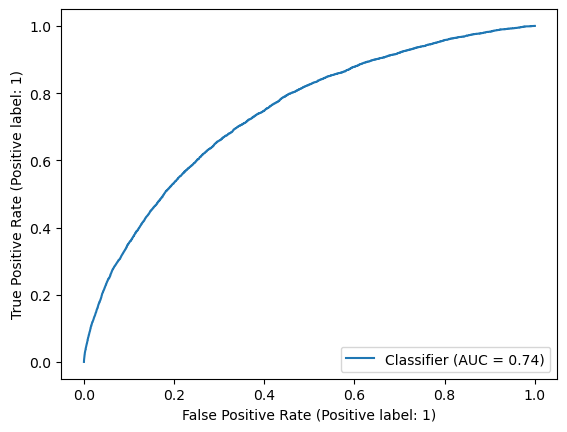

In [90]:
# Draw ROC curve
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(y_test, base_model.predict_proba(X_test)[:, 1])

In [111]:
len(base_model.models)

5

In [92]:
base_model_feature_importance = base_model.get_average_shap_feature_importance(X_train)

In [93]:
base_model.feature_importances_shap_

,feature,importance
0,ANNUITY_TO_CREDIT,0.140965
1,GOODS_TO_CREDIT,0.138091
2,NAME_EDUCATION_TYPE,0.110246
3,OCCUPATION_TYPE,0.103849
4,DAYS_BIRTH,0.090873
...,...,...
571,w90_share_overdue_gt90,0.000000
572,bb_w12_status_0_share__max,0.000000
573,w30_debt_concentration_active,0.000000
574,FLAG_DOCUMENT_11,0.000000


In [96]:
# Draw shap summary plot from the base_model get_average_shap_values
base_model.get_feature_importance(X_train)


,feature,importance
0,ANNUITY_TO_CREDIT,12.604933
1,GOODS_TO_CREDIT,5.462461
2,DAYS_BIRTH,4.658373
3,NAME_EDUCATION_TYPE,3.992955
4,OCCUPATION_TYPE,3.104900
...,...,...
571,w90_share_overdue_gt90,0.000000
572,bb_w12_status_0_share__max,0.000000
573,w30_debt_concentration_active,0.000000
574,FLAG_DOCUMENT_11,0.000000


In [97]:
base_model.feature_importances_

,feature,importance
0,ANNUITY_TO_CREDIT,12.604933
1,GOODS_TO_CREDIT,5.462461
2,DAYS_BIRTH,4.658373
3,NAME_EDUCATION_TYPE,3.992955
4,OCCUPATION_TYPE,3.104900
...,...,...
571,w90_share_overdue_gt90,0.000000
572,bb_w12_status_0_share__max,0.000000
573,w30_debt_concentration_active,0.000000
574,FLAG_DOCUMENT_11,0.000000


In [36]:
X_test.columns[1]

'bb_w3_months_count__mean'

In [ ]:
base_model.get_average_feature_interaction_score(X_train)

,Feature_1,Feature_2,Score
0,FONDKAPREMONT_MODE,NAME_EDUCATION_TYPE,0.792759
1,WEEKDAY_APPR_PROCESS_START,NAME_HOUSING_TYPE,0.515831
2,NAME_FAMILY_STATUS,FONDKAPREMONT_MODE,0.449159
3,bb_w24_status_3_share__mean,NAME_EDUCATION_TYPE,0.395999
4,bb_w24_status_3_share__mean,FONDKAPREMONT_MODE,0.383623
...,...,...,...
3133,w90_utilization_portfolio,WALLSMATERIAL_MODE,0.000042
3134,WEEKDAY_APPR_PROCESS_START,w360_avg_overdue_active,0.000023
3135,bb_w12_status_0_share__mean,REGION_RATING_CLIENT_W_CITY,0.000016
3136,w90_max_overdue_amt,NAME_INCOME_TYPE,0.000013


In [ ]:
base_model.feature_interaction_

,Feature_1,Feature_2,Score
0,FONDKAPREMONT_MODE,NAME_EDUCATION_TYPE,0.792759
1,WEEKDAY_APPR_PROCESS_START,NAME_HOUSING_TYPE,0.515831
2,NAME_FAMILY_STATUS,FONDKAPREMONT_MODE,0.449159
3,bb_w24_status_3_share__mean,NAME_EDUCATION_TYPE,0.395999
4,bb_w24_status_3_share__mean,FONDKAPREMONT_MODE,0.383623
...,...,...,...
3133,w90_utilization_portfolio,WALLSMATERIAL_MODE,0.000042
3134,WEEKDAY_APPR_PROCESS_START,w360_avg_overdue_active,0.000023
3135,bb_w12_status_0_share__mean,REGION_RATING_CLIENT_W_CITY,0.000016
3136,w90_max_overdue_amt,NAME_INCOME_TYPE,0.000013


In [44]:
base_model_feature_importance.loc[base_model_feature_importance['importance']>0].nunique()

feature       487
importance    487
dtype: int64

In [26]:
list_features_top200 = base_model_feature_importance['feature'].tolist()[:200]

In [112]:
X_train['FLAG_OWN_CAR'].value_counts()

FLAG_OWN_CAR
N    152206
Y     78427
Name: count, dtype: int64

In [76]:
X_train[['CREDIT_TO_INCOME']].describe()

,CREDIT_TO_INCOME
count,230633.000000
mean,3.961270
std,2.684589
min,0.004808
25%,2.022400
50%,3.274533
75%,5.166133
max,35.477778


In [89]:
base_model.used_features

['bb_w3_share_status_gt0__mean',
 'bb_w3_status_5_share__mean',
 'bb_w12_status_max__mean',
 'bb_w24_status_mean__mean',
 'bb_w6_status_0_share__sum',
 'bb_w6_status_max__max',
 'bb_w3_status_4_share__sum',
 'bb_w12_longest_streak_status_gt0__max',
 'w90_annuity_over_total_debt',
 'bb_w24_share_unknown__sum',
 'bb_w12_status_1_share__mean',
 'w30_high_util_card_any',
 'w180_debt_concentration_active',
 'w720_share_overdue_gt90',
 'bb_w6_status_4_share__mean',
 'bb_w12_status_mean__mean',
 'ENTRANCES_MODE',
 'NAME_INCOME_TYPE',
 'w720_expo_growth_abs',
 'w360_last_loan_debt',
 'ID_PUBLISH_YEARS_AGO',
 'w180_expo_concentration',
 'bb_w24_share_status_gt4__mean',
 'w90_avg_days_remaining',
 'w90_n_closed_loans',
 'w720_last_loan_debt',
 'bb_w24_status_0_share__sum',
 'bb_w6_status_5_share__sum',
 'bb_w24_longest_streak_status_gt0__sum',
 'bb_w6_months_since_last_status_gt0__sum',
 'bb_w24_share_status_gt4__sum',
 'w360_active_ratio',
 'FLAG_DOCUMENT_2',
 'w90_short_term_risk',
 'bb_w12_sh

In [98]:
X_test[X_test[base_model.cat_features].isnull().any(axis=1)]

,bb_w3_share_status_gt0__mean,bb_w3_status_5_share__mean,bb_w12_status_max__mean,bb_w24_status_mean__mean,bb_w6_status_0_share__sum,bb_w6_status_max__max,bb_w3_status_4_share__sum,bb_w12_longest_streak_status_gt0__max,w90_annuity_over_total_debt,bb_w24_share_unknown__sum,...,FLAG_DOCUMENT_15,FLOORSMAX_MODE,bb_w6_status_3_share__sum,bb_w24_status_max__sum,bb_w6_status_max__mean,w90_type_diversity_shannon,bb_w24_status_max__max,DEF_60_CNT_SOCIAL_CIRCLE,bb_w24_months_count__mean,bb_w24_share_status_gt3__max


In [90]:
base_model.cat_features

['OCCUPATION_TYPE',
 'w90_last_loan_type',
 'NAME_HOUSING_TYPE',
 'w360_last_loan_type',
 'NAME_FAMILY_STATUS',
 'NAME_EDUCATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'w30_last_loan_type',
 'HOUSETYPE_MODE',
 'w180_last_loan_type',
 'EMERGENCYSTATE_MODE',
 'FONDKAPREMONT_MODE',
 'NAME_TYPE_SUITE',
 'ORGANIZATION_TYPE',
 'FLAG_OWN_CAR',
 'WALLSMATERIAL_MODE',
 'FLAG_OWN_REALTY',
 'NAME_INCOME_TYPE',
 'NAME_CONTRACT_TYPE',
 'w720_last_loan_type']

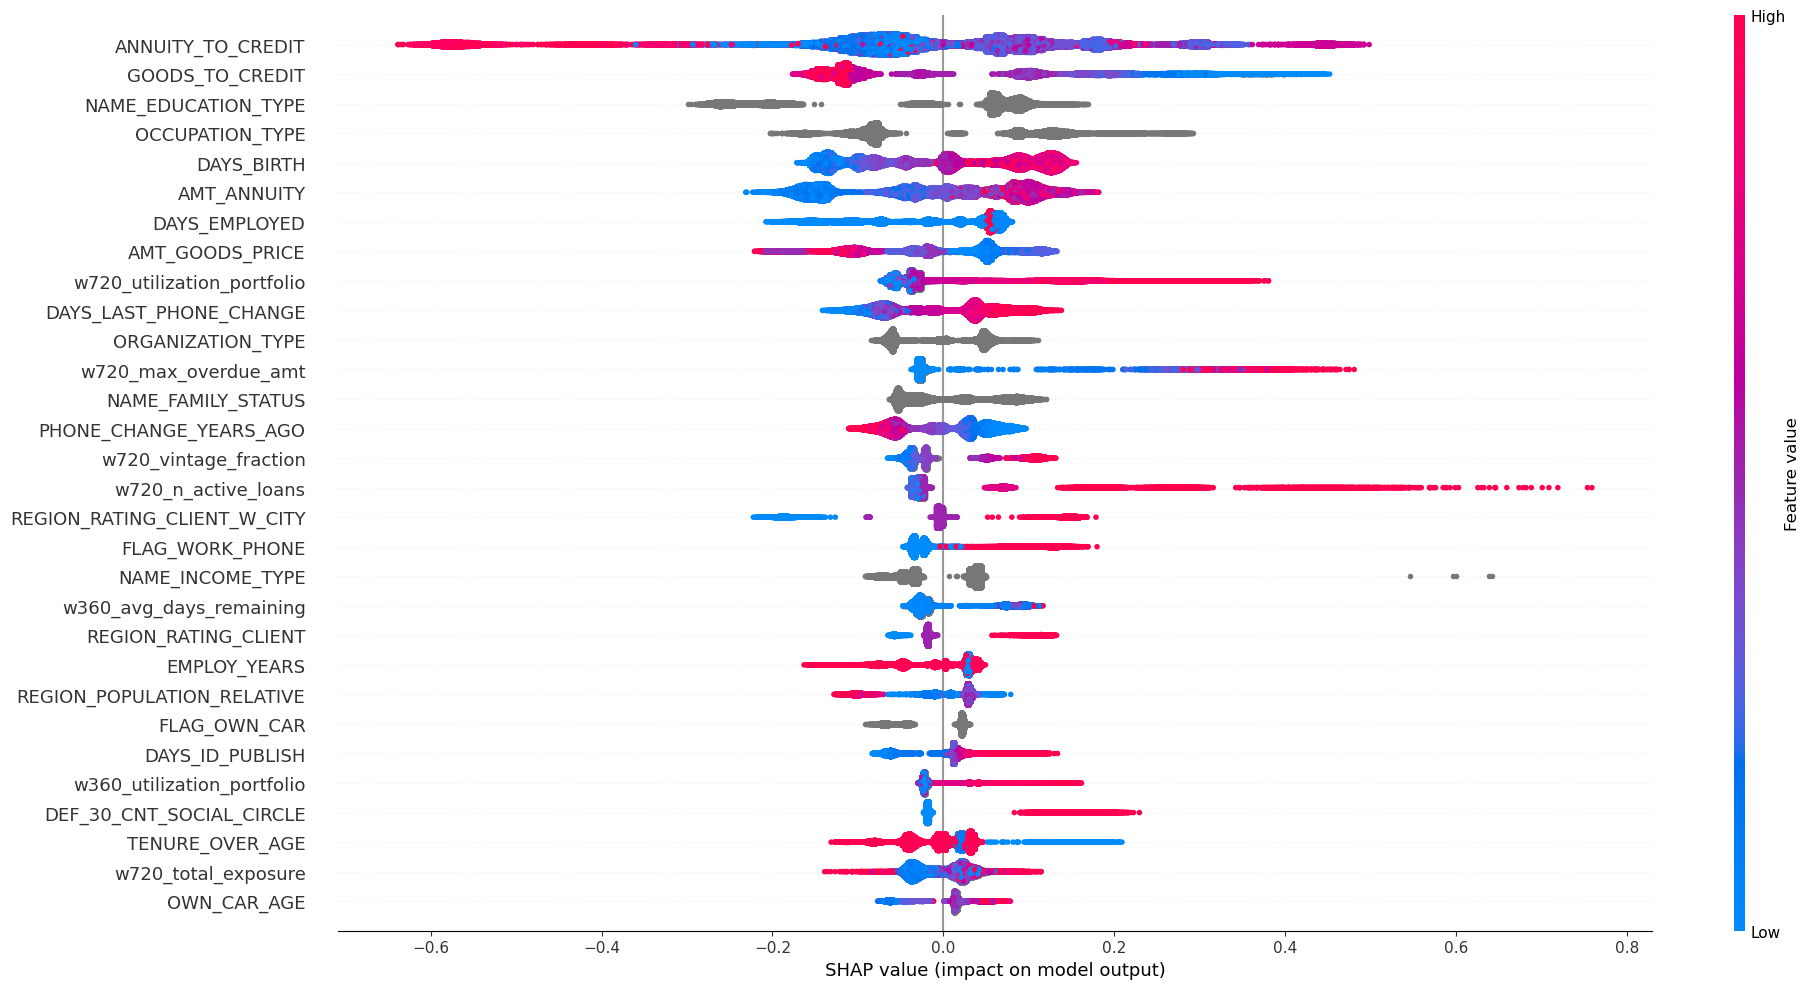

In [99]:
base_model.plot_shap_summary_plot(X_test, max_display=30, plot_size=(20,10))